In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats as ss
from scipy import stats
import scipy.io as sio
from statsmodels import robust
%matplotlib inline

In [2]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
fish = pd.read_csv('fish_100.csv', sep = ",")

### Calculate fatigue

In [4]:
fish['tap_count']=[1]*len(fish)
# fatigue per environment

In [5]:
tap = fish.groupby(['id', 'environment'])['tap_count'].cumsum().reset_index(name = 'fatigue')

In [6]:
tap = tap.reset_index().set_index('index')
tap = tap.drop('level_0', axis =1)

In [7]:
fish = tap.merge(fish, left_index = True, right_index=True,how='inner')

### Exclusion List

In [8]:
fish = fish[~fish.id.isin([668262.0, 675528.0, 675577.0, 680119.0, 672593.0, 683242.0, 675654.0])]
# failed sound check questions 

### Missing Values

In [9]:
fish.isnull().sum()
fish = fish[fish.latency.notnull()]

Checkpoint

In [10]:
len(fish.id.unique()) #93

93

### Environment + latency

In [11]:
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment_binary'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment_binary'])
fish['log_latency'] = np.log(fish['latency'])

# Why mixed model?

A linear regression model assumes the following things:
(https://www.statisticssolutions.com/assumptions-of-multiple-linear-regression/)
1. First, multiple linear regression requires the relationship between the independent and dependent variables to be linear. 
2. Second, the multiple linear regression analysis requires that the errors between observed and predicted values (i.e., the residuals of the regression) should be normally distributed. (i.i.d)
3. Third, multiple linear regression assumes that there is no multicollinearity in the data.  Multicollinearity occurs when the independent variables are too highly correlated with each other.


We measured action initiation latency multiple times for the same environment and price. Thus, the current dataset has repeated measures for the same variable, violating the second rule. 

# Why random intercept?

Everyone has a different baseline. Adding a baseline action initiation latency to everyone.

In [12]:
plot = fish.groupby(['id', 'price_displayed', 'environment'])['latency'].mean().reset_index(name = 'average_latency')


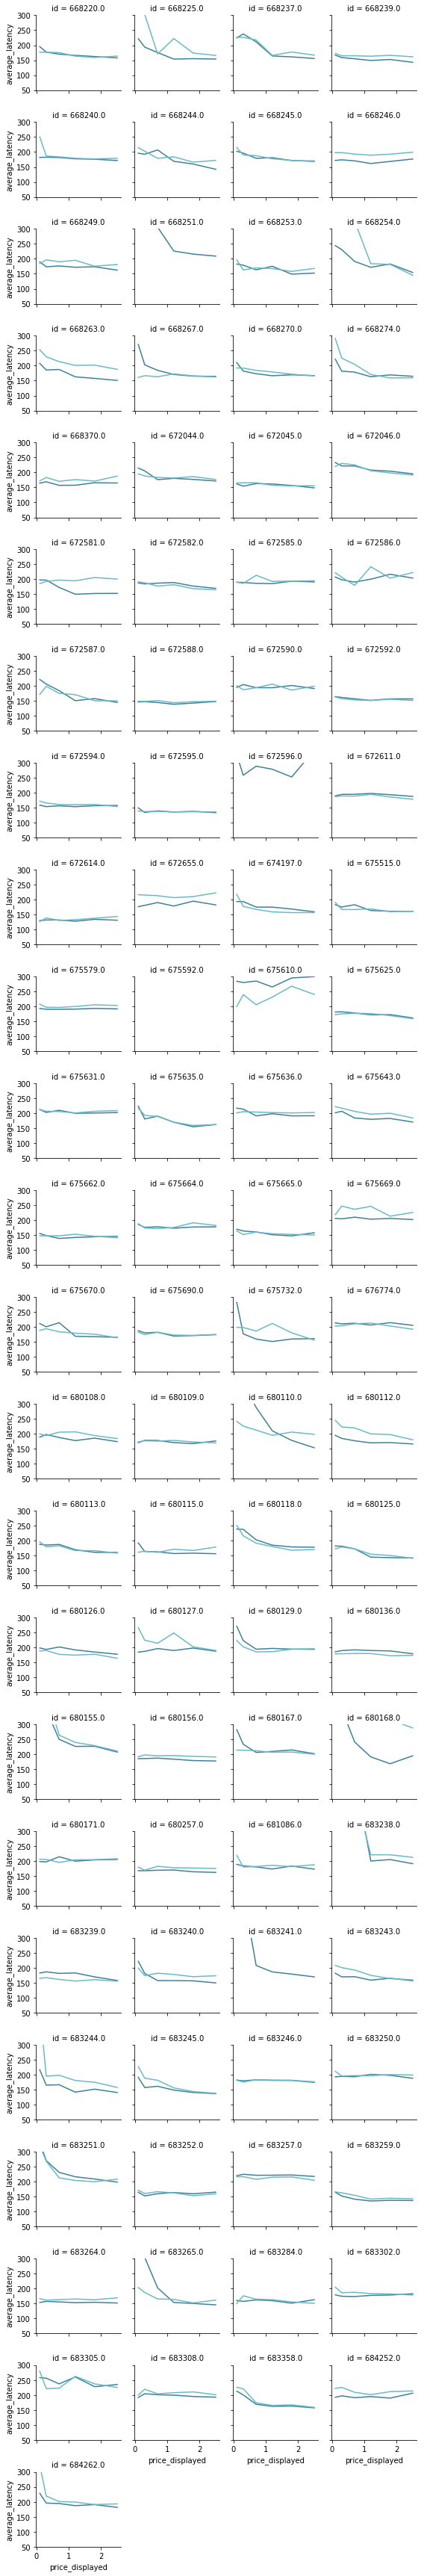

In [19]:
g = sns.FacetGrid(plot, col="id", col_wrap=4, height=2, ylim=(50, 300))
g.map(sns.lineplot,'price_displayed','average_latency', 'environment', palette = "GnBu_d", legend = 'full',
      err_style="bars")
#sns.boxplot(x="id", y="latency", hue = 'environment_binary', data=fish)

#plt.ylim(50, 280)

In [13]:
tap_plt = fish.groupby(['id', 'environment'])['tap_count'].sum().reset_index(name = 'fatigue')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


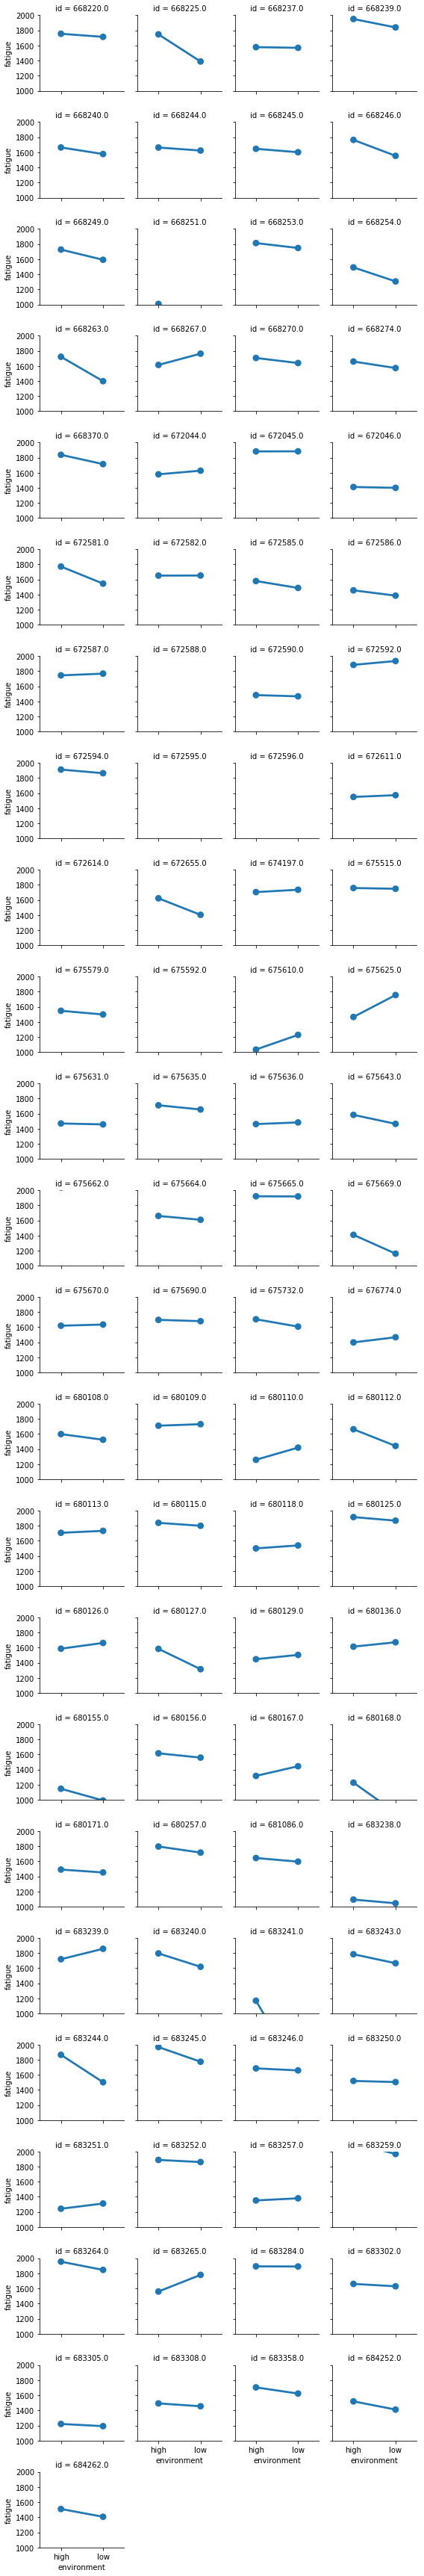

In [21]:
g = sns.FacetGrid(tap_plt, col="id", col_wrap=4, height=2, ylim=(1000, 2000))
g.map(sns.pointplot,'environment','fatigue');
#sns.boxplot(x="id", y="latency", hue = 'environment_binary', data=fish)

#plt.ylim(50, 280)

# Log Linear Model

Need to pick an optimizer.
<br>Matlab uses either 'bfgs' or 'lbfgs'. But Matlab doesn't give convergence information.


## Powell

In [14]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue',
                  groups = fish['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = fish)

r = f_model.fit(reml = False, method = 'powell')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [15]:
print(r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             295026            Method:                       ML         
No. Groups:                   93                Scale:                        0.0559     
Min. group size:              1355              Likelihood:                   5816.9870  
Max. group size:              4507              Converged:                    Yes        
Mean group size:              3172.3                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.252    0.023 231.399 0.000  5.207  5.296
environment_binary[T.1]             

### Calculate AIC

In [16]:
sm.tools.eval_measures.aic(5816.9870, 295026, 4)

-11625.974

## Quasi-Newton

In [17]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue',
                  groups = fish['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = fish)

r = f_model.fit(reml = False, method = 'bfgs', maxiter = 100000)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [18]:
print(r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             295026            Method:                       ML         
No. Groups:                   93                Scale:                        0.0559     
Min. group size:              1355              Likelihood:                   5816.9875  
Max. group size:              4507              Converged:                    Yes        
Mean group size:              3172.3                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.252    0.023 231.526 0.000  5.207  5.296
environment_binary[T.1]             

In [38]:
sm.tools.eval_measures.aic(5816.9875 , 295026, 4)

-11625.975

In [60]:
sm.tools.eval_measures.bic(5816.9875, 295026, 4)

-11583.595724931874

## Compare this to matlab betas

In [29]:
matlab_beta = pd.read_csv('akshay_betas.csv', sep = ",")
matlab_beta['id']=matlab_beta['id'].astype('str')
matlab_beta.set_index('id', inplace = True)

In [30]:
betas = matlab_beta.merge(random_effects, right_index = True, left_index = True, how = 'inner')

In [31]:
betas['diff_env'] = betas['environment']- betas['environment_binary[T.1]']

In [32]:
np.sum(np.abs(betas['diff_env']))

0.11931373430525377

In [33]:
betas['diff_price'] = betas['price']- betas['price_displayed']

In [34]:
np.sum(np.abs(betas['diff_price']))

0.005390165318752839

## Visualization

## Random Effects

In [24]:
r_params = pd.DataFrame(r.params,columns=['LMM'])
random_effects = pd.DataFrame(r.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

In [25]:
len(random_effects) # 93

93

In [26]:
random_effects.head(2)

,Group,environment_binary[T.1],price_displayed,fatigue
668220.0,-0.08355,0.04820,0.00370,-0.00005
668225.0,0.11717,-0.10620,-0.08723,-0.00004


Text(0.5, 1.0, 'Histogram for Environment Betas')

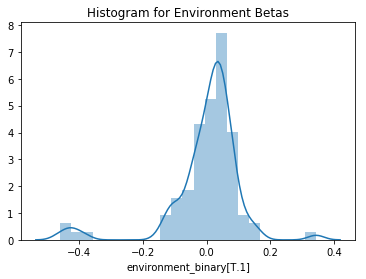

In [36]:
sns.distplot(random_effects['environment_binary[T.1]'])
plt.title('Histogram for Environment Betas')

Text(0.5, 1.0, 'Histogram for Price Betas')

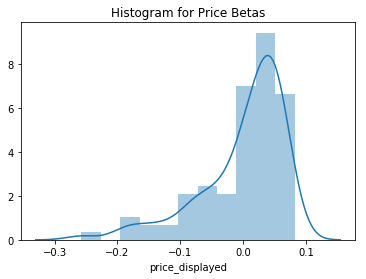

In [37]:
sns.distplot(random_effects['price_displayed'])
plt.title('Histogram for Price Betas')

## Environment betas and tap difference

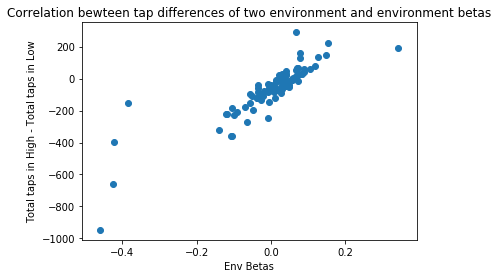

In [43]:
tap = fish.groupby(['id', 'environment'])['tap_count'].sum().reset_index(name = 'difference')
tap = tap.groupby(tap.index//2)['difference'].diff(-1).dropna().reset_index()

y = -1*tap['difference']
x = random_effects['environment_binary[T.1]']
plt.title('Correlation bewteen tap differences of two environment and environment betas')
plt.xlabel('Env Betas')
plt.ylabel('Total taps in High - Total taps in Low')
plt.scatter(x, y)